In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def tridiag(a, b, c, d):
    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = bc[it-1]/ac[it-1]
        ac[it] = ac[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
        	    
    xc = ac
    xc[-1] = dc[-1]/ac[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/ac[il]

    return xc

In [3]:
# def TDMA(a,b,c,d):
#     n = len(d)
#     w= np.zeros(n-1,float)
#     g= np.zeros(n, float)
#     p = np.zeros(n,float)
    
#     w[0] = c[0]/a[0]
#     g[0] = d[0]/a[0]

#     for i in range(1,n-1):
#         w[i] = c[i]/(a[i] - b[i-1]*w[i-1])
#     for i in range(1,n):
#         g[i] = (d[i] - b[i-1]*g[i-1])/(a[i] - b[i-1]*w[i-1])
#     p[n-1] = g[n-1]
#     for i in range(n-1,0,-1):
#         p[i-1] = g[i-1] - w[i-1]*p[i]
#     return p

In [4]:
# def Make_Tridiagonal_Matrix(a, b, c):
#     n = len(a)
#     U = []
#     for j in range(n):
#         temp = np.zeros(n)
#         temp[j] = a[j]
#         if j != 0:
#             if j != n - 1:
#                 temp[j+1] = c[j]
#             temp[j-1] = b[j]
#         else:
#             temp[j+1] = c[j]
#         U.append(list(temp))
#     return U

# def Thomas_algorithm(arr, d):    
#     n = len(d)
#     a_prime = np.zeros(n)
#     d_prime = np.zeros(n)
#     x = np.zeros(n)
    
#     a_prime[0] = arr[0][0]
#     d_prime[0] = d[0]
    
#     for i in range(1, n):
#         a_prime[i] = arr[i][i] - arr[i-1][i] * (arr[i][i-1] / a_prime[i-1]) 
#         d_prime[i] = d[i] - d_prime[i-1] * (arr[i][i-1] / a_prime[i-1])
    
#     x[n-1] = d_prime[n-1] / a_prime[n-1]
    
#     for j in range(n-2,-1,-1):
#         x[j] = (d_prime[j]/a_prime[j]) - (arr[j][j+1]/a_prime[j]) * x[j+1]
    
#     return x

In [5]:
# Official Price = 9193.47

# Parameters
S0 = 200 # reference price of underlying asset
T = 3    # Maturation of contract
cr = np.array([0.025, 0.045, 0.0675, 0.09, 0.1125, 0.135]) # Coupon rate of return on each early redemption date
K = np.array([0.98, 0.98, 0.95, 0.95, 0.90, 0.85])  # Exercise price on each early redemption date
d = np.array([0.5, 1, 1.5, 2, 2.5, 3]) # Early redemption date
B = 0.59 # Knock-In barrier level
sigma = 0.2785 # Volatility of the underlying asset
r = 0.0177 # Interest rate
q = 0 # Dividend

In [6]:
# Spacing
dx = S0*0.01  # chnage of 1% of current price
Nx = 400      # Number of space(S) points 
Smax = dx*Nx  # Max price of the underlying asset 
Smin = 0
pp = 50       # Number of time points in each 6 month
Nt = 6*pp     # Total number of time points (monthly frequency)
dt = T/Nt     # Time step
Rtag = 2*d*pp # Time step of early redemption date
S0tag = 0     # Node number of current price
Btag = 0      # Node number of barrier 

for j in range(1, Nx+2):
    if j*dx <= S0:
        S0tag+=1
    if j*dx <= S0*B:
        Btag+=1

In [7]:
def ELS_Onestar_IFDM(Smin, Smax, sig, rf, D, S0, cr, K, B, T, Nx, Nt, dt, Rtag, Btag):
    
    # Computational domain
    S = np.linspace(Smin, Smax, Nx+1)
    x = S/S0
    
    u = np.zeros([Nt+1, Nx+1])
    w = np.zeros([Nt+1, Nx+1])
    
    x_h = np.arange(1, Nx)
    
    # Coefficients of x for IFDM and boundary condition adjusted
    a = 1 + dt*(rf + (sig**2)*(x_h)**2)
    b = (dt/2)*((rf-D)*x_h - (sig**2)*(x_h**2))
    c = (dt/2)*(-(rf-D)*x_h - (sig**2)*(x_h**2))
    
    a[0] = a[0] + 2*b[0]
    c[0] = c[0] - b[0]
    
    a[Nx-2] = a[Nx-2] + 2*c[Nx-2]
    b[Nx-2] = b[Nx-2] - c[Nx-2]
    
    # Initial conditions
    for j in range(Nx+1):
        if x[j] > B:
            u[0][j] = (1 + cr[5])
        else:
            u[0][j] = x[j]
        if x[j] >= K[5]:
            w[0][j] = (1 + cr[5])
        else:
            w[0][j] = x[j]
    
    # Linear boundary condition
    u[1:,0] = 2*u[1:,1] - u[1:,2]
    u[1:,-1] = 2*u[1:,-2] - u[1:,-3]
    w[1:,0] = 2*w[1:,1] - w[1:,2]
    w[1:,-1] = 2*w[1:,-2] - w[1:,-3]
    
    for n in range(1, Nt+1):
        
        # Early redemption
        for j in range(5):
            if n == (Rtag[j]-1):
                dummy = int(np.ceil(S0tag*K[4-j]))
                dummy-=1
                u[n,dummy:] = 1 + cr[4-j]
                w[n,dummy:] = 1 + cr[4-j]
                
        d = u[n-1,1:Nx]
        u[n,1:Nx] = tridiag(a,b[1:],c[:-1],d)
        d = w[n-1,1:Nx]
        w[n,1:Nx] = tridiag(a,b[1:],c[:-1],d)
        u[n,1:Btag-1] = w[n,1:Btag-1]
                
        u[n,0] = 2*u[n,1] - u[n,2]
        u[n,-1] = 2*u[n,-2] - u[n,-3]
        w[n,0] = 2*w[n,1] - w[n,2]
        w[n,-1] = 2*w[n,-2] - w[n,-3]
    
    price = u
    
    return price

In [8]:
price = ELS_Onestar_IFDM(Smin, Smax, sigma, r, q, S0, cr, K, B, T, Nx, Nt, dt, Rtag, Btag)

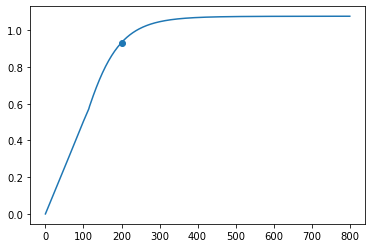

In [9]:
S = np.linspace(Smin, Smax, Nx+1)
plt.plot(S, price[Nt,:])
plt.scatter(S0, price[Nt,S0tag])
plt.show()

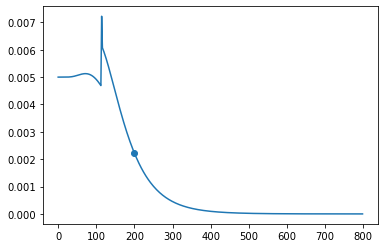

In [10]:
delta = (price[Nt,1:] - price[Nt,:-1])/dx
idx = int(S0/dx)
plt.plot(S[:-1], delta)
plt.scatter(S0, delta[idx])
plt.show()

In [11]:
print("Price : ", price[Nt,S0tag])
print("Delta : ", delta[idx])

Price :  0.9329759047690266
Delta :  0.002219069315171629
